In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [2]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function with your model and test generator


In [4]:
train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 13307 images belonging to 26 classes.
Found 1684 images belonging to 26 classes.
{0: 1.0640492563569486, 1: 1.0662660256410257, 2: 1.0662660256410257, 3: 1.0402595372107568, 4: 1.2273565762774397, 5: 1.0381494772975504, 6: 1.053102247546692, 7: 1.2795192307692307, 8: 1.0487862547288778, 9: 1.053102247546692, 10: 0.6486789509603198, 11: 1.0662660256410257, 12: 1.4623076923076923, 13: 0.8809082483781279, 14: 0.7571119708693673, 15: 1.0466414975617429, 16: 1.7527660695468914, 17: 0.5415954415954416, 18: 1.0662660256410257, 19: 0.9042538733351454, 20: 0.789826685660019, 21: 1.5462468045549616, 22: 1.0256667180514876, 23: 1.8085077466702908, 24: 1.0445054945054946, 25: 0.7259683578832515}


In [5]:
!pip install keras_cv_attention_models 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.5/787.5 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.6:
      Successfully uninstalled wcwidth-0.2.6


In [6]:
from keras_cv_attention_models import wave_mlp

In [10]:
from keras_cv_attention_models import coatnet

In [7]:
def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(256, activation='relu')(x)  # Add your own dense layers
    x = Dropout(0.5)(x)  # Add dropout for regularization
    x = Dense(num_classes, activation='softmax')(x)
    return x



def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = coatnet.CoAtNet0(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
#     head_output = custom_head(mm_headless.output, num_classes)
    print("mm_headless.output shape:", mm_headless.output_shape)
    head_output = custom_head(mm_headless.output, num_classes)


    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
# custom_model.summary()

NameError: name 'coatnet' is not defined

In [7]:
def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = coatnet.CoAtNet0(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-100]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()

NameError: name 'coatnet' is not defined

In [8]:
def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
# custom_model.summary()

69906376/69906376 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/wavemlp_t_imagenet.h5


In [9]:
mm_last_layer = custom_model .get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(custom_model .input, mm_last_layer)

In [10]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
Total params: 16,704,736
Trainable params: 16,680,160
Non-trainable params: 24,576
_________________________________________________________________


In [11]:
num_classes = 26
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
 output_1 (Dense)            (None, 26)                13338     
                                                                 
Total params: 16,718,074
Trainable params: 16,693,498
Non-trainable params: 24,576
_________________________________________________________________


In [12]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [14]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_33/2027776823.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/30
832/831 [==============================] - ETA: 0s - loss: 1.4523 - accuracy: 0.5607 - categorical_accuracy: 0.5607 - auc: 0.9440 - precision: 0.7564 - recall: 0.4106 - true_positives: 5464.0000 - true_negatives: 330915.0000 - false_positives: 1760.0000 - false_negatives: 7843.0000 - cohen_kappa: 0.5424 - f1_score: 0.5549
Epoch 1: val_accuracy improved from -inf to 0.32779, saving model to Best_DenseNet201_v23.h5
831/831 [==============================] - 386s 376ms/step - loss: 1.4523 - accuracy: 0.5607 - categorical_accuracy: 0.5607 - auc: 0.9440 - precision: 0.7564 - recall: 0.4106 - true_positives: 5464.0000 - true_negatives: 330915.0000 - false_positives: 1760.0000 - false_negatives: 7843.0000 - cohen_kappa: 0.5424 - f1_score: 0.5549 - val_loss: 4.3657 - val_accuracy: 0.3278 - val_categorical_accuracy: 0.3278 - val_auc: 0.7351 - val_precision: 0.3592 - val_recall: 0.2910 - val_true_positives: 490.0000 - val_true_negatives: 41226.0000 - val_false_positives: 874.0000 - va

In [18]:
features = final_model.predict_generator(generator_test)

/tmp/ipykernel_33/1249813240.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  features = final_model.predict_generator(generator_test)


In [20]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

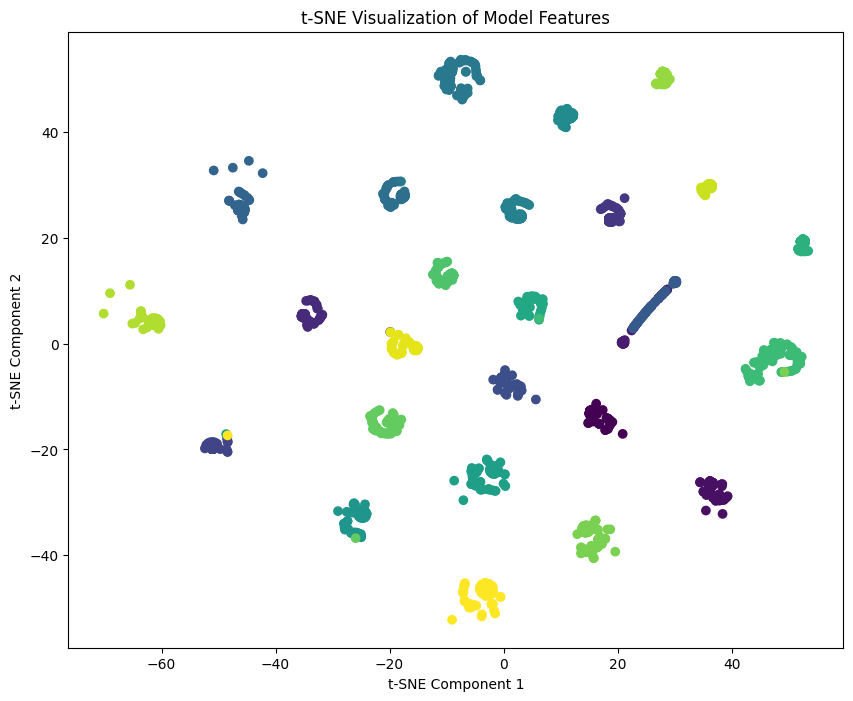

In [21]:
# Flatten the features
features_flat = features.reshape(features.shape[0], -1)

# Assuming 'labels' is a list/array of class labels for each image in the test set
labels = generator_test.classes

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features_flat)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Visualization of Model Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [6]:
from keras_cv_attention_models import beit

In [7]:
from keras_cv_attention_models import swin_transformer_v2

In [8]:
from keras_cv_attention_models import swin_transformer_v2
mm = swin_transformer_v2.SwinTransformerV2Tiny_window8(input_shape=(112, 112, 3))

>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_window8_256_imagenet.h5


In [9]:
# from keras_cv_attention_models import nat

mm2 =beit.BeitBasePatch16(input_shape=(224, 224, 3))


/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


>>>> Load pretrained from: /root/.keras/models/beit_base_patch16_224_imagenet21k-ft1k.h5


In [18]:
mm_last_layer = custom_model .get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(custom_model .input, mm_last_layer)

In [12]:
mm_last_layer = mm2 .get_layer('out_ln').output
# out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
# out = Dense(11, activation='softmax', name='prediction1')(out)
mm2_custom = Model(mm2 .input,mm_last_layer )

In [15]:
mm_last_layer = mm2 .get_layer('stack4_block5_2_output').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(mm2 .input, mm_last_layer)

from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])


NameError: name 'mm2' is not defined

In [ ]:
# from tensorflow.keras import layers

# inputs = keras.Input(shape=(112, 112, 3))
# mm_last_layer = mm2.get_layer('stack4_block5_2_output').output
# outputs = layers.average([mm_last_layer])

# avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)


In [19]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_7 (Functional)        (None, 768)               22487658  
                                                                 
 average_1 (Average)         (None, 768)               0         
                                                                 
Total params: 22,487,658
Trainable params: 22,476,010
Non-trainable params: 11,648
_________________________________________________________________


In [ ]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(224,224,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

In [ ]:
# !pip install --upgrade keras_cv_attention_models


In [12]:
num_classes = 26
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
 output_1 (Dense)            (None, 26)                13338     
                                                                 
Total params: 16,718,074
Trainable params: 16,693,498
Non-trainable params: 24,576
_________________________________________________________________


In [13]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet2013_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [15]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_32/2027776823.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/30
832/831 [==============================] - ETA: 0s - loss: 1.5334 - accuracy: 0.5354 - categorical_accuracy: 0.5354 - auc: 0.9359 - precision: 0.7516 - recall: 0.3906 - true_positives: 5198.0000 - true_negatives: 330957.0000 - false_positives: 1718.0000 - false_negatives: 8109.0000 - cohen_kappa: 0.5163 - f1_score: 0.5287
Epoch 1: val_accuracy improved from -inf to 0.37173, saving model to Best_DenseNet2013_v23.h5
831/831 [==============================] - 358s 346ms/step - loss: 1.5334 - accuracy: 0.5354 - categorical_accuracy: 0.5354 - auc: 0.9359 - precision: 0.7516 - recall: 0.3906 - true_positives: 5198.0000 - true_negatives: 330957.0000 - false_positives: 1718.0000 - false_negatives: 8109.0000 - cohen_kappa: 0.5163 - f1_score: 0.5287 - val_loss: 2.4273 - val_accuracy: 0.3717 - val_categorical_accuracy: 0.3717 - val_auc: 0.8711 - val_precision: 0.4443 - val_recall: 0.3171 - val_true_positives: 534.0000 - val_true_negatives: 41432.0000 - val_false_positives: 668.0000 - v

In [ ]:
# load model
from tensorflow.keras.models import load_model
model1 = load_model("/kaggle/working/Best_DenseNet2013_v23.h5")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from keras.layers import Conv2D, Add, Concatenate

def mhsa_block(x, num_heads=4, ff_dim=None):
    if ff_dim is None:
        ff_dim = x.shape[-1]

    # MHSA (Multi-Head Self Attention)
    mhsa = MultiHeadSelfAttention(num_heads=num_heads, key_dim=ff_dim // num_heads)(x)
    mhsa = Dropout(0.3)(mhsa)
    mhsa = LayerNormalization(epsilon=1e-6)(mhsa)
    mhsa = Add()([x, mhsa])  # Residual connection

    # Feed Forward
    ff = Conv2D(ff_dim, kernel_size=1, activation='relu')(mhsa)
    ff = Dropout(0.3)(ff)
    ff = Conv2D(x.shape[-1], kernel_size=1)(ff)
    ff = Dropout(0.3)(ff)
    ff = Add()([mhsa, ff])  # Residual connection

    return ff

def lvit_block(x, num_heads=4, ff_dim=None):
    # Clone the input
    clone = Conv2D(x.shape[-1], kernel_size=1, strides=2)(x)

    # Apply MHSA to one branch
    mhsa_branch = mhsa_block(x, num_heads=num_heads, ff_dim=ff_dim)

    # Concatenate the MHSA branch output with the cloned input
    out = Concatenate()([clone, mhsa_branch])

    # 1x1 convolution to compress dimension and maintain the block's dimension
    out = Conv2D(x.shape[-1], kernel_size=1, strides=2)(out)

    return out

def modify_wave_mlp_with_lvit(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Apply LViT block
    lvit_output = lvit_block(mm_headless.output, num_heads=4, ff_dim=512)

    # Add your custom head
    head_output = custom_head(lvit_output, num_classes)

    # Create the custom model by combining the base model, LViT block, and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model_with_lvit = modify_wave_mlp_with_lvit(input_shape, num_classes)
custom_model_with_lvit.summary()


In [ ]:
from keras.layers import GlobalAveragePooling2D

def modify_wave_mlp_with_lvit(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Apply Global Average Pooling to reduce dimensions
    gap_output = GlobalAveragePooling2D()(mm_headless.output)

    # Reshape output to match the original shape
    reshaped_output = Reshape((1, 1, mm_headless.output.shape[-1]))(gap_output)

    # Apply LViT block
    lvit_output = lvit_block(reshaped_output, num_heads=4, ff_dim=512)

    # Add your custom head
    head_output = custom_head(lvit_output, num_classes)

    # Create the custom model by combining the base model, LViT block, and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model_with_lvit = modify_wave_mlp_with_lvit(input_shape, num_classes)
custom_model_with_lvit.summary()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, MultiHeadAttention, Dropout, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def custom_head(input_tensor, num_classes):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def lvit_block(x, mhsa_channels, strides=1, dropout_rate=0.1):
    # Clone the input
    input_clone = x

    # Apply DW Conv to reduce computations
    x = DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Apply 1x1 Conv to expand or decrease dimension
    x = Conv2D(mhsa_channels, 1, padding='same')(x)

    # Pass one branch through MHSA module
    x = MultiHeadAttention(num_heads=4, key_dim=mhsa_channels // 4)(x, x)
    x = Dropout(dropout_rate)(x)

    # Concatenate the output of MHSA with the cloned input
    x = Concatenate()([input_clone, x])

    # Apply 1x1 Conv to compress dimension with a stride of 2
    x = Conv2D(mhsa_channels, 1, strides=2, padding='same')(x)

    return x

def custom_lvit(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)

    # LViT block
    x = lvit_block(x, mhsa_channels=256, strides=1, dropout_rate=0.3)

    # Add your custom head
    head_output = custom_head(x, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=inputs, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in custom_model.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = custom_lvit(input_shape, num_classes)
custom_model.summary()


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_cv_attention_models import wave_mlp, nat

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless_wave_mlp = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head for WaveMLP
    head_output_wave_mlp = custom_head(mm_headless_wave_mlp.output, num_classes)

    # Create the custom model for WaveMLP by combining the base model and the custom head
    custom_model_wave_mlp = Model(inputs=mm_headless_wave_mlp.input, outputs=head_output_wave_mlp)

    # Fine-tune the last few layers of the base model for WaveMLP
    for layer in mm_headless_wave_mlp.layers[:-5]:
        layer.trainable = True

    return custom_model_wave_mlp

# Example usage for WaveMLP:
input_shape_wave_mlp = (112, 112, 3)
num_classes_wave_mlp = 26  # Adjust based on your task

custom_model_wave_mlp = modify_wave_mlp(input_shape_wave_mlp, num_classes_wave_mlp)
custom_model_wave_mlp.summary()

# Load DiNAT_Mini model
mm_nat = nat.DiNAT_Mini(input_shape=(374, 269, 3), pretrained="imagenet")

# Combine the models
combined_input = Concatenate()([custom_model_wave_mlp.output, mm_nat.output])

# Add a fusion layer, you can customize this layer based on your needs
fusion_layer = Dense(256, activation='relu')(combined_input)
fusion_layer = Dropout(0.3)(fusion_layer)

# Add the final output layer
final_output = Dense(num_classes_wave_mlp, activation='softmax')(fusion_layer)

# Create the combined model
combined_model = Model(inputs=[custom_model_wave_mlp.input, mm_nat.input], outputs=final_output)

# Compile the combined model
combined_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

# Example usage for the combined model:
combined_model.summary()


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_cv_attention_models import wave_mlp, nat

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu', name='custom_dense_1')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', name='custom_dense_2')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax', name='custom_output')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless_wave_mlp = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head for WaveMLP
    head_output_wave_mlp = custom_head(mm_headless_wave_mlp.output, num_classes)

    # Create the custom model for WaveMLP by combining the base model and the custom head
    custom_model_wave_mlp = Model(inputs=mm_headless_wave_mlp.input, outputs=head_output_wave_mlp)

    # Fine-tune the last few layers of the base model for WaveMLP
    for layer in mm_headless_wave_mlp.layers[:-5]:
        layer.trainable = True

    return custom_model_wave_mlp

# Example usage for WaveMLP:
input_shape_wave_mlp = (112, 112, 3)
num_classes_wave_mlp = 26  # Adjust based on your task

custom_model_wave_mlp = modify_wave_mlp(input_shape_wave_mlp, num_classes_wave_mlp)
custom_model_wave_mlp.summary()

# Load DiNAT_Mini model
mm_nat = nat.DiNAT_Mini(input_shape=(374, 269, 3), pretrained="imagenet")

# Combine the models
combined_input = Concatenate(name='combined_input')([custom_model_wave_mlp.output, mm_nat.output])

# Add a fusion layer, you can customize this layer based on your needs
fusion_layer = Dense(256, activation='relu', name='fusion_dense_1')(combined_input)
fusion_layer = Dropout(0.3)(fusion_layer)

# Add the final output layer
final_output = Dense(num_classes_wave_mlp, activation='softmax', name='final_output')(fusion_layer)

# Create the combined model
combined_model = Model(inputs=[custom_model_wave_mlp.input, mm_nat.input], outputs=final_output)

# Compile the combined model
combined_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

# Example usage for the combined model:
combined_model.summary()


In [ ]:
from keras_cv_attention_models import wave_mlp
mm = wave_mlp.WaveMLP_T(input_shape=(112, 112, 3), pretrained="imagenet")

In [ ]:
from keras_cv_attention_models import nat

mm2 = nat.NAT_Mini(input_shape=(112, 112, 3))


In [ ]:
mm_last_layer = custom_model .get_layer('dense_2').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(custom_model .input, mm_last_layer)

In [ ]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

In [ ]:
num_classes = 26
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

In [ ]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [ ]:
epochs = 5

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

In [ ]:
np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


In [ ]:
from keras_cv_attention_models import wave_mlp

In [ ]:
!pip install tensorflow-addons


In [ ]:
from tensorflow_addons.layers import MultiHeadAttention


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

from tensorflow_addons.layers import MultiHeadSelfAttention

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

from tensorflow_addons.layers import MultiHeadAttention

from tensorflow_addons.layers import MultiHeadAttention

def add_attention_layers(base_model_output):
    # Add self-attention for global analysis
    attention_global = MultiHeadAttention(
        num_heads=8, key_dim=512, dropout=0.3
    )(base_model_output, base_model_output, return_attention_scores=False)
    x = GlobalAveragePooling2D()(attention_global)

    # Add self-attention for local analysis
    attention_local = MultiHeadAttention(
        num_heads=8, key_dim=512, dropout=0.3
    )(base_model_output, base_model_output, return_attention_scores=False)
    x_local = Flatten()(attention_local)

    # Concatenate global and local attention features
    x = Concatenate()([x, x_local])

    return x


def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add attention layers for local and global analysis
    attention_output = add_attention_layers(mm_headless.output)

    # Add your custom head
    head_output = custom_head(attention_output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()


In [ ]:
!pip install keras-self-attention

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras_self_attention import SeqSelfAttention
from keras_cv_attention_models import wave_mlp

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir, target_size=(112, 112), batch_size=batch_size, shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir, target_size=(112, 112), batch_size=batch_size, shuffle=False)

# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

from keras_self_attention import SeqSelfAttention

def create_local_global_layer(input_tensor):
    # Local Attention
    local_attention = SeqSelfAttention(
        attention_width=15,
        attention_activation='sigmoid',
        name='LocalAttention',
    )(input_tensor)

    # Multiplicative Attention
    multiplicative_attention = SeqSelfAttention(
        attention_width=15,
        attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
        attention_activation=None,
        kernel_regularizer=keras.regularizers.l2(1e-6),
        use_attention_bias=False,
        name='MultiplicativeAttention',
    )(input_tensor)

    return local_attention, multiplicative_attention

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Global Average Pooling on the output
    x = GlobalAveragePooling2D()(mm_headless.output)

    # Reshape to (batch_size, 1, 1, channels)
    x = Reshape((1, 1, -1))(x)

    # Add the local and multiplicative attention layers
    local_attention, multiplicative_attention = create_local_global_layer(x)

    # Reshape attention outputs to match the shape of mm_headless.output
    local_attention = Reshape((-1,))(local_attention)
    multiplicative_attention = Reshape((-1,))(multiplicative_attention)

    # Concatenate the attention outputs with mm_headless.output
    concatenated_attention = Concatenate()([mm_headless.output, local_attention, multiplicative_attention])

    # Add your custom head on top of the concatenated attention output
    head_output = custom_head(concatenated_attention, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()


In [ ]:
!pip install keras-multi-head

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras_multi_head import MultiHead
from keras_cv_attention_models import wave_mlp
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import Embedding, concatenate 

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

!pip install keras_cv_attention_models 

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp_with_multihead(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the MultiHead model
    multihead_model = Sequential()  # Make sure to import Sequential from keras.models
    multihead_model.add(Embedding(input_dim=5, output_dim=3, name='Embed'))  # Add the Embedding layer
    multihead_model.add(MultiHead(
        layer=keras.layers.Bidirectional(keras.layers.LSTM(units=16), name='LSTM'),
        layer_num=5,
        reg_index=[1, 4],
        reg_slice=(slice(None, None), slice(32, 48)),
        reg_factor=0.1,
        name='Multi-Head-Attention',
    ))
    multihead_model.add(Flatten(name='Flatten'))
    multihead_model.add(Dense(units=num_classes, activation='softmax', name='Dense'))

    # Combine the base model, custom head, and MultiHead model
    combined_output = concatenate([head_output, multihead_model.output])  # Connect the outputs
    combined_model = Model(inputs=mm_headless.input, outputs=combined_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    combined_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return combined_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

combined_model = modify_wave_mlp_with_multihead(input_shape, num_classes)
combined_model.summary()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))




def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()


train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)



!pip install keras_cv_attention_models 


from keras_cv_attention_models import wave_mlp


def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()


In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

def generate_gradcam(model, img_path, layer_name, num_classes):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (112, 112))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier=None, clone=False)

    # Generate heatmap
    cam = gradcam(img_array, penultimate_layer=layer_name, backprop_modifier=None, grad_modifier=None)

    # Render heatmap
    heatmap = np.uint8(255 * normalize(cam))

    # Resize heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap (jet) to the heatmap
    jet = plt.get_cmap("jet")
    heatmap = jet(heatmap)

    # Superimpose heatmap on the original image
    superimposed_img = (heatmap[:, :, :3] * 0.4 + img * 0.6).astype(np.uint8)

    # Plot the original image, heatmap, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Superimposed Image")
    plt.show()

# Example usage:
# Choose an image from the test set
sample_img_path = "/kaggle/input/mango-leaf/mango-prepo/train/Aprupali/Amrupali (163).jpg"
img_class = generator_test.classes[0]  # Replace with the actual class of the image
img_class_name = list(generator_test.class_indices.keys())[img_class]

# Generate Grad-CAM visualization for the chosen image
generate_gradcam(custom_model, sample_img_path, 'your_target_layer_name', num_classes)


In [ ]:
def generate_grad_cam(model, img_path, class_index, preprocess_input_fn):
    # Load the image and preprocess it
    img = cv2.imread(img_path)
    img = cv2.resize(img, (112, 112))
    img = preprocess_input_fn(img)
    img_array = np.expand_dims(img, axis=0)

    # Get the last convolutional layer and the model's output
    last_conv_layer = model.get_layer('dense_11')
    classifier_layer_names = [
        layer.name for layer in model.layers if layer.name.endswith('dense_layer_name')]

    # Create a model that maps the input image to the activations of the last conv layer and output
    grad_model = Model([model.inputs], [last_conv_layer.output, model.get_layer(classifier_layer_names[0]).output])

    # Get the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        class_channel = preds[:, class_index]

    grads = tape.gradient(class_channel, last_conv_output)

    # Compute the guided gradients
    guided_grads = tf.cast(last_conv_output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Compute the average of the gradients over each feature map
    weights = tf.reduce_mean(guided_grads, axis=(1, 2))

    # Build a weighted sum of the activations of the last conv layer
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_output), axis=-1)

    # Normalize the CAM
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    # Resize the CAM to match the input image size
    cam = cv2.resize(cam[0], (112, 112))

    # Convert the CAM to the range [0, 255]
    cam = np.uint8(255 * cam)

    # Apply a colormap to the CAM
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    # Combine the heatmap with the original image
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image, heatmap, and superimposed image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image')
    plt.show()


# Example usage:
def preprocess_input(img):
    img = img.astype('float32') / 255.0
    return img

# Assuming you have a test image path
test_image_path = '/kaggle/input/mango-leaf/mango-prepo/train/Aprupali/Amrupali (163) flip.png'
img_class_index = 0  # Change this based on the class you want to visualize
generate_grad_cam(custom_model, test_image_path, img_class_index, preprocess_input)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras_cv_attention_models import wave_mlp
from tensorflow.keras.preprocessing import image


np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


def get_grad_cam(model, img_path, layer_name):
    img = image.load_img(img_path, target_size=(112, 112))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale to [0,1]

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = np.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def evaluate_with_grad_cam(model, generator_test, img_path):
    model.evaluate(generator_test)

    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

    # Get Grad-CAM for a sample image
    img_heatmap = get_grad_cam(model, img_path, layer_name="multiply_1230")

    # Load the original image
    original_img = cv2.imread(img_path)

    # Resize heatmap to the size of the original image
    heatmap_resized = cv2.resize(img_heatmap, (original_img.shape[1], original_img.shape[0]))

    # Convert heatmap to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap_colored * 0.4 + original_img * 0.6

    # Display the original image, heatmap, and superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_colored)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img.astype(int))
    plt.title('Superimposed Image')

    plt.show()


train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=num_classes, average='weighted')])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
# custom_model.summary()

# Example usage of evaluate_with_grad_cam
evaluate_with_grad_cam(custom_model, generator_test, img_path="/kaggle/input/mango-leaf/mango-prepo/train/Aprupali/Amrupali (163) random_gaussian_noise.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from tensorflow.keras.layers import UpSampling2D

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


def build_autoencoder(input_shape):
    # Build a simple convolutional autoencoder
    # You can customize this architecture based on your requirements
    autoencoder_input = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(autoencoder_input)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPool2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(autoencoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Use Mean Squared Error as loss for reconstruction
    
    return autoencoder


def train_autoencoder(autoencoder, generator_train):
    # Train the autoencoder on your training data
    autoencoder.fit(generator_train, epochs=10, steps_per_epoch=len(generator_train), verbose=1)


def extract_encoder_from_autoencoder(autoencoder):
    # Extract encoder part from the trained autoencoder
    encoder = Model(autoencoder.input, autoencoder.layers[4].output)  # Adjust layer index based on your autoencoder architecture
    return encoder


# Create and train autoencoder
input_shape = (112, 112, 3)  # Adjust based on your image dimensions
autoencoder = build_autoencoder(input_shape)
train_autoencoder(autoencoder, generator_train)

# Extract encoder from autoencoder
encoder = extract_encoder_from_autoencoder(autoencoder)

# Build classification model with encoder
classification_model = Sequential([
    encoder,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(generator_train.num_classes, activation='softmax')
])

# Compile the model
classification_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train classification model
history = classification_model.fit(generator_train, epochs=10, validation_data=generator_test)

# Evaluate the model
evaluate_(classification_model, generator_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


def build_autoencoder(input_shape):
    # Build a simple convolutional autoencoder
    # You can customize this architecture based on your requirements
    autoencoder_input = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(autoencoder_input)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPool2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='linear', padding='same')(x)  # Use 'linear' activation instead of 'sigmoid'
    decoded_reshaped = Reshape(input_shape)(decoded)  # Reshape to match input shape

    autoencoder = Model(autoencoder_input, decoded_reshaped)
    autoencoder.compile(optimizer='adam', loss='mse')  # Use Mean Squared Error as loss for reconstruction
    
    return autoencoder


def train_autoencoder(autoencoder, generator_train):
    # Train the autoencoder on your training data
    autoencoder.fit(generator_train, epochs=10, steps_per_epoch=len(generator_train), verbose=1)


def extract_encoder_from_autoencoder(autoencoder):
    # Extract encoder part from the trained autoencoder
    encoder = Model(autoencoder.input, autoencoder.layers[4].output)  # Adjust layer index based on your autoencoder architecture
    return encoder


def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()


# Paths
train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"

# Data Generators
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

# Create and train autoencoder
input_shape = (112, 112, 3)  # Adjust based on your image dimensions
autoencoder = build_autoencoder(input_shape)
train_autoencoder(autoencoder, generator_train)

# Extract encoder from autoencoder
encoder = extract_encoder_from_autoencoder(autoencoder)

# Build classification model with encoder
classification_model = Sequential([
    encoder,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(generator_train.num_classes, activation='softmax')
])

# Compile the model
classification_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train classification model
history = classification_model.fit(generator_train, epochs=10, validation_data=generator_test)

# Evaluate the model
evaluate_(classification_model, generator_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


# Autoencoder Model
def build_autoencoder(input_shape):
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model


def evaluate_(model, generator_test):
    model.evaluate(generator_test)

    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()


train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Build and compile the autoencoder
autoencoder_input_shape = (112, 112, 3)
autoencoder = build_autoencoder(autoencoder_input_shape)
autoencoder.compile(optimizer='adam', loss='mse')  # Use Mean Squared Error for loss

# Train the autoencoder on your training data
autoencoder.fit(generator_train.next(), generator_train.next(), epochs=10, batch_size=batch_size)

# Use the encoder part of the autoencoder to obtain encoded representations
encoded_train_data = autoencoder.layers[0].predict(generator_train.next())

# Classification Model using the encoded data
classification_model = Sequential()
classification_model.add(Flatten(input_shape=(encoded_train_data.shape[1:])))
classification_model.add(Dense(256, activation='relu'))
classification_model.add(Dropout(0.5))
classification_model.add(Dense(generator_train.num_classes, activation='softmax'))

# Compile the classification model
classification_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Train the classification model using the encoded data
classification_model.fit(encoded_train_data, keras.utils.to_categorical(generator_train.classes),
                          epochs=10, batch_size=batch_size, class_weight=class_weights)

# Evaluate the model
evaluate_(classification_model, generator_test)


In [ ]:
def generate_grad_cam(model, img_path, class_index, preprocess_input_fn):
    # Load the image and preprocess it
    img = cv2.imread(img_path)
    img = cv2.resize(img, (112, 112))
    img = preprocess_input_fn(img)
    img_array = np.expand_dims(img, axis=0)

    # Get the last convolutional layer and the model's output
    last_conv_layer = model.get_layer('dense_11')
    classifier_layer_name = 'dense_2'  # Replace with the actual name of your dense layer

    # Create a model that maps the input image to the activations of the last conv layer and output
    grad_model = Model([model.inputs], [last_conv_layer.output, model.get_layer(classifier_layer_name).output])

    # Get the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        class_channel = preds[:, class_index]

    grads = tape.gradient(class_channel, last_conv_output)

    # Compute the guided gradients
    guided_grads = tf.cast(last_conv_output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Compute the average of the gradients over each feature map
    weights = tf.reduce_mean(guided_grads, axis=(1, 2))

    # Build a weighted sum of the activations of the last conv layer
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_output), axis=-1)

    # Normalize the CAM
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    # Resize the CAM to match the input image size
    cam = cv2.resize(cam[0], (112, 112))

    # Convert the CAM to the range [0, 255]
    cam = np.uint8(255 * cam)

    # Apply a colormap to the CAM
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    # Combine the heatmap with the original image
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image, heatmap, and superimposed image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image')
    plt.show()


# Example usage:
def preprocess_input(img):
    img = img.astype('float32') / 255.0
    return img

# Assuming you have a test image path
test_image_path = '/kaggle/input/mango-leaf/mango-prepo/train/Aprupali/Amrupali (163) flip.png'
img_class_index = 0  # Change this based on the class you want to visualize
generate_grad_cam(custom_model, test_image_path, img_class_index, preprocess_input)


In [ ]:
!pip install tf-keras-vis


In [ ]:
from keras_cv_attention_models import WaveMLP, DPTAttention

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def add_attention_layers(base_model_output):
    # Add self-attention for global analysis
    attention_global = DPTAttention(output_dim=512, num_heads=8, name='attention_global')(base_model_output)
    x = GlobalAveragePooling2D()(attention_global)

    # Add self-attention for local analysis
    attention_local = DPTAttention(output_dim=512, num_heads=8, name='attention_local')(base_model_output)
    x_local = Flatten()(attention_local)

    # Concatenate global and local attention features
    x = Concatenate()([x, x_local])

    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = WaveMLP.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add attention layers for local and global analysis
    attention_output = add_attention_layers(mm_headless.output)

    # Add your custom head
    head_output = custom_head(attention_output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()


In [ ]:
def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(256, activation='relu')(x)  # Add your own dense layers
    x = Dropout(0.5)(x)  # Add dropout for regularization
    x = Dense(num_classes, activation='softmax')(x)
    return x



def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
#     head_output = custom_head(mm_headless.output, num_classes)
    print("mm_headless.output shape:", mm_headless.output_shape)
    head_output = custom_head(mm_headless.output, num_classes)


    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
# custom_model.summary()

In [ ]:
def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# def custom_head(input_tensor, num_classes):
#     x = Flatten()(input_tensor)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(num_classes, activation='softmax')(x)
#     return x

# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam


# # Define your custom_head function
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Define your custom_head function

# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Define your custom_head function

# def autoencoder(base_model_output):
#     # Extract the shape of the output tensor from the base model
#     output_shape = base_model_output.shape[1:]

#     # Check if output_shape is valid (at least 3 dimensions)
#     if len(output_shape) < 3:
#         raise ValueError("Invalid output_shape. It should have at least 3 dimensions.")

#     # Extract the relevant information from output_shape
#     height, width, channels = output_shape[0], output_shape[1], output_shape[2]

#     # Calculate the input shape based on the output shape
#     input_shape = (height // 4, width // 4, channels)

#     # Encoder
#     encoder_input = Input(shape=input_shape)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
#     x = MaxPooling2D((2, 2), padding='same')(x)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     encoded = MaxPooling2D((2, 2), padding='same')(x)

#     # Decoder
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D((2, 2))(x)
#     decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)

#     autoencoder_model = Model(encoder_input, decoded)
#     autoencoder_model.compile(optimizer='adam', loss='mse')  # Adjust the loss function as needed

#     return autoencoder_model

# def modify_wave_mlp(input_shape, num_classes):
#     # Load the WaveMLP model without the top layers (head)
#     mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

#     # Obtain the output tensor from the last layer in the base model
#     base_model_output = mm_headless.layers[-1].output

#     # Create an autoencoder with input shape matching the last layer shape of the base model
#     autoencoder_model = autoencoder(base_model_output)

#     # Connect the autoencoder to the base model
#     autoencoder_input = Input(shape=base_model_output.shape[1:])
#     autoencoder_output = autoencoder_model(autoencoder_input)

#     # Add your custom head for classification
#     classification_output = custom_head(autoencoder_output, num_classes)

#     # Create the custom model by combining the base model, autoencoder, and the custom head
#     custom_model = Model(inputs=[mm_headless.input, autoencoder_input], outputs=[classification_output, autoencoder_output])

#     # Fine-tune the last few layers of the base model
#     for layer in mm_headless.layers[:-15]:
#         layer.trainable = True

#     # Compile the model with appropriate loss functions and metrics
#     custom_model.compile(optimizer=Adam(lr=1e-4), 
#                          loss=['categorical_crossentropy', 'mse'], 
#                          loss_weights=[1.0, 0.5],  # Adjust the weight for the autoencoder loss
#                          metrics={'dense_3': 'accuracy', 'model_4': 'mse'})

#     return custom_model

# # Example usage:
# input_shape = (112, 112, 3)
# num_classes = 26  # Adjust based on your task

# custom_model = modify_wave_mlp(input_shape, num_classes)
# custom_model.summary()



In [ ]:
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def get_gradcam(model, img_path, class_index, layer_name='your_last_conv_layer'):
    # Load the image with target size
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = imagenet_utils.preprocess_input(img_array)

    # Get the class predictions and the target layer's output
    preds, last_conv_output = model.predict(img_array)
    class_output = preds[0, class_index]

    # Compute the gradient of the class output with respect to the feature map
    grads = K.gradients(class_output, last_conv_output)[0]

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Access the value of the target layer output
    iterate = K.function([model.input], [pooled_grads, last_conv_output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img_array])

    # Weigh the output feature map with the computed gradient values
    for i in range(pooled_grads.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Average the weighted feature map along the channel dimension to obtain the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize the heatmap to be the same as the input image
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

# Specify the path to an image for visualization
img_path = '/kaggle/input/mango-leaf/mango-prepo/val/Baper Bari/Bbari (1002) flip.png'

# Choose the index of the class you want to visualize
class_index = 0

# Visualize Grad-CAM
gradcam_img = get_gradcam(custom_model, img_path, class_index)
plt.imshow(gradcam_img)
plt.show()


In [ ]:
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ... (rest of your code)

def get_gradcam(model, img_path, class_index, layer_name='your_last_conv_layer'):
    # Load the image with target size
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = imagenet_utils.preprocess_input(img_array)

    # Get the class predictions and the target layer's output
    last_conv_output = model.predict(img_array)
    class_output = last_conv_output[0, class_index]

    # Compute the gradient of the class output with respect to the feature map
    grads = K.gradients(class_output, last_conv_output)[0]

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Access the value of the target layer output
    iterate = K.function([model.input], [pooled_grads, last_conv_output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img_array])

    # Weigh the output feature map with the computed gradient values
    for i in range(pooled_grads.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Average the weighted feature map along the channel dimension to obtain the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize the heatmap to be the same as the input image
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

# ... (rest of your code)

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()

# Specify the path to an image for visualization
img_path = '/kaggle/input/mango-leaf/mango-prepo/val/Baper Bari/Bbari (1002) flip.png'

# Choose the index of the class you want to visualize
class_index = 0

# Visualize Grad-CAM
gradcam_img = get_gradcam(custom_model, img_path, class_index)
plt.imshow(gradcam_img)
plt.show()


In [ ]:
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import matplotlib.pyplot as plt

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def autoencoder(input_shape):
    # Encoder
    encoder_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder_model = Model(encoder_input, decoded)
    autoencoder_model.compile(optimizer='adam', loss='mse')  # Adjust the loss function as needed

    return autoencoder_model

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Get the shape of the last layer in the base model
    base_model_output_shape = mm_headless.layers[-1].output_shape

    # Check if output_shape is valid (at least 3 dimensions)
    if len(base_model_output_shape) < 3:
        raise ValueError("Invalid output_shape. It should have at least 3 dimensions.")

    # Create an autoencoder with input shape matching the last layer shape of the base model
    autoencoder_model = autoencoder(base_model_output_shape[1:])

    # Connect the autoencoder to the base model
    autoencoder_input = Input(shape=base_model_output_shape[1:])
    autoencoder_output = autoencoder_model(autoencoder_input)

    # Add your custom head for classification
    classification_output = custom_head(autoencoder_output, num_classes)

    # Create the custom model by combining the base model, autoencoder, and the custom head
    custom_model = Model(inputs=[mm_headless.input, autoencoder_input], outputs=[classification_output, autoencoder_output])

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with appropriate loss functions and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), 
                         loss=['categorical_crossentropy', 'mse'], 
                         loss_weights=[1.0, 0.5],  # Adjust the weight for the autoencoder loss
                         metrics={'dense_3': 'accuracy', 'model_1': 'mse'})

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()

# ... (rest of your code)


In [ ]:
# Specify the path to an image for visualization
img_path = '/kaggle/input/mango-leaf/mango-prepo/val/Baper Bari/Bbari (1002) flip.png'

# Choose the index of the class you want to visualize
class_index = 0

# Visualize Grad-CAM
gradcam_img = get_gradcam(custom_model, img_path, class_index)
plt.imshow(gradcam_img)
plt.show()

In [ ]:
mm_last_layer = custom_model .get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(custom_model .input, mm_last_layer)

In [ ]:
print("mm_headless.output shape:", mm_headless.output_shape)
head_output = custom_head(mm_headless.output, num_classes)


In [ ]:
from keras_cv_attention_models import coatnet
mm = coatnet.CoAtNet0(input_shape=(112, 112, 3), pretrained="imagenet")

In [ ]:
from keras_cv_attention_models import coatnet
mm = coatnet.CoAtNet0(input_shape=(112, 112, 3), pretrained="imagenet")

In [ ]:
from keras_cv_attention_models import res_mlp
# mm = res_mlp.ResMLP12()

In [ ]:
mm = res_mlp.ResMLP12(input_shape=(112, 112, 3), pretrained="imagenet")

In [ ]:
from keras_cv_attention_models import wave_mlp
mm = wave_mlp.WaveMLP_T(input_shape=(112, 112, 3), pretrained="imagenet")

In [ ]:
from keras_cv_attention_models import mobilevit
mm = mobilevit.MobileViTBasePatch16(input_shape=(112, 112, 3))
mm2 = mobilevit.MobileViTBasePatch16(input_shape=(112, 112, 3))


In [ ]:
# mm.summary()

In [ ]:
from keras_cv_attention_models import swin_transformer_v2

In [ ]:
mm2 = swin_transformer_v2.SwinTransformerV2Tiny_window8(input_shape=(112, 112, 3))

In [ ]:
# mm2.summary()

In [ ]:
"""
transfer_layer = mm.get_layer('avg_pool')
conv_model = Model(inputs=mm.input, outputs=transfer_layer.output)
"""

In [ ]:
"""
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))
"""

In [ ]:
from keras_cv_attention_models import beit
mm2 = beit.BeitBasePatch16(input_shape=(112, 112, 3))

In [ ]:
mm_last_layer = mm.get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(mm.input, mm_last_layer)

In [ ]:
mm2_last_layer = mm2.get_layer('avg_pool').output
#out2 = Dense(256, activation='relu', name='dense_1')(mm2_last_layer)
#out2 = Dense(11, activation='softmax', name='prediction1')(out2)
mm2_custom = Model(mm2.input, mm2_last_layer)

In [ ]:
# Define a custom linear attention layer
class LinearAttentionLayer(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(LinearAttentionLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores / tf.math.sqrt(tf.cast(self.units, tf.float32)), axis=-1)
        output = tf.matmul(attn_scores, V)

        return output

# ... Continue with your code ...

# Add the attention layer where needed in your model
num_classes = 2
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output

# Add Linear Attention Layer here (for example, just before the output layer)
attention_output = LinearAttentionLayer(64)(avg_ensemble_model_last_layer)

output_layer = Dense(num_classes, activation='softmax', name='output_1')(attention_output)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

In [ ]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([ mm2_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

In [ ]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm2_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

In [ ]:
num_classes = 26
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average_3').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

In [ ]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os

# Delete the existing HDF5 file if it exists
if os.path.exists('Best_DenseNet201.h5'):
    os.remove('Best_DenseNet201.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [ ]:
epochs = 10

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

In [ ]:
evaluate_(final_model, generator_test)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!pip install --upgrade scipy scikit-image


In [ ]:
image_size = 128
batch_size = 8

train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
val_dir = r"/kaggle/input/mango-leaf/mango-prepo/val"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"


datagen_train = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,
                                  horizontal_flip=True,  vertical_flip=False)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=train_dir, target_size=(image_size, image_size),
                                                    batch_size=batch_size, shuffle=True)
val_generator = datagen_test.flow_from_directory(directory=val_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)
test_generator = datagen_test.flow_from_directory(directory=test_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)

#Define the number of classes in your dataset
num_classes = train_generator.num_classes

In [ ]:
from tensorflow.keras.layers import Layer, Attention
import numpy as np

In [ ]:
class LinearAttention(Layer):
    def __init__(self, units):
        super(LinearAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores / tf.math.sqrt(tf.cast(self.units, tf.float32)), axis=-1)
        output = tf.matmul(attn_scores, V)

        return output


In [ ]:
# Define your model function with attention
def modelfunction_with_attention(base):
    x = base.output

    # Add Self-Attention Layer
    att_output = LinearAttention(128)(x)

    # Add more layers if needed
    x = tf.keras.layers.GlobalAveragePooling2D()(att_output)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model

In [ ]:
def modelfunction(base):
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model

def get_callbacks(weight):
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    callbacks = [checkpoint, learning_rate_reduction]
    return callbacks

def evaluate(model, generator_test):
    model.evaluate(generator_test)

    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

def model_training(base, weight, epochs):
    model = modelfunction(base)
    print("\n\n\n-------------------- Model Initialized --------------------")

    callbacks = get_callbacks(weight)
    metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
               tfa.metrics.CohenKappa(num_classes=num_classes), tfa.metrics.F1Score(num_classes=num_classes)]
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=metrics)

    history = model.fit(train_generator, steps_per_epoch=366 // batch_size,
                        validation_data=val_generator,  # Add this line
                        epochs=epochs, callbacks=callbacks)
    # Plotting accuracy and loss curves
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n\n\n-------------------- Evaluation --------------------")
    evaluate(model, val_generator)

    return model


In [ ]:
# Create and train the model with attention
VGG19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)
VGG19_model_with_attention = model_training(VGG19, 'VGG19_with_attention.h5', 10)

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random


In [ ]:
from lime import lime_image

In [ ]:
from skimage.segmentation import mark_boundaries